In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [97]:
data = pd.read_csv (r'data_clean_4_21.csv')

## Data sources:
USDA Rural-Urban Continuum Codes    
https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx   
US census income and poverty data   
https://www.census.gov/data/tables/2019/demo/income-poverty/p60-266.html   
Covid-19 health system capacity   
https://github.com/covidcaremap/covid19-healthsystemcapacity/tree/master/data       
NY times covid-19 cases/deaths count   
https://github.com/nytimes/covid-19-data      
There are some reported cases/deaths in unknown/unavailable counties areas.

## Exploratory Analysis

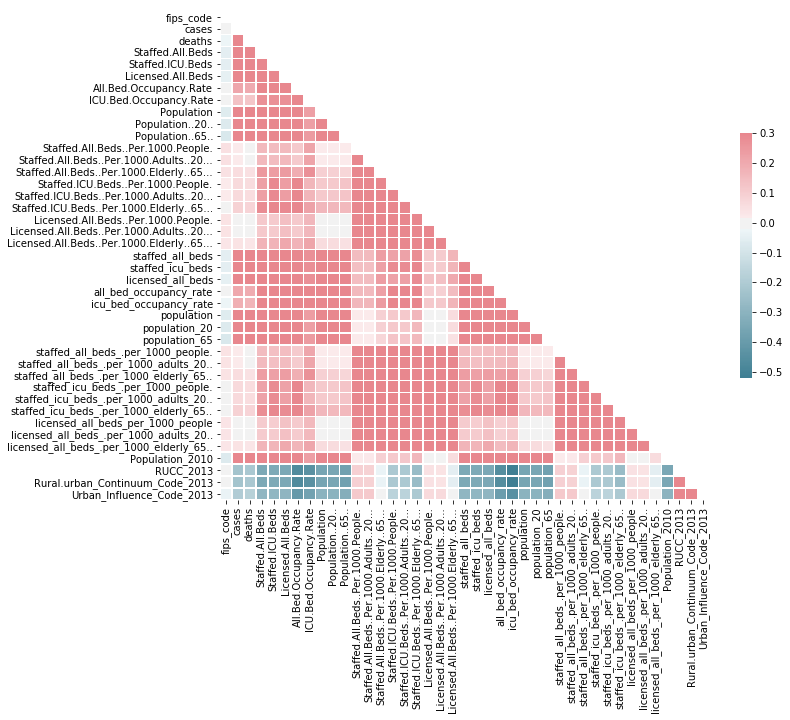

In [3]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x)

Top 25 counties with most cases and deaths distributed in the following states: 

In [22]:
data.columns

Index(['fips_code', 'date', 'county', 'state', 'cases', 'deaths', 'State',
       'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x',
       'staffed_all_beds', 'staffed_icu_beds', 'licensed_all_beds',
       'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population',
       'population_20', 'population_65', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       's

In [6]:
data1 = data[['cases', 'deaths', 'state', 'county_x']]
top = data1.sort_values(['cases', 'deaths'], ascending=False).head(30)
unique(list(top['state']))

New York
Illinois
California
Michigan
New Jersey
Florida
Pennsylvania
Massachusetts
Connecticut
Louisiana
Washington
Texas


Top states with most cases and deaths across all counties:

In [7]:
data1.groupby(['state']).sum().sort_values(['cases', 'deaths'], ascending=False).head(11)

,cases,deaths
state,,
New York,251720,14828
New Jersey,92387,4753
Massachusetts,41199,1961
California,35844,1316
Pennsylvania,35384,1620
Illinois,33059,1479
Michigan,32936,2698
Florida,27861,866
Louisiana,24854,1405


Text(0,0.5,'deathes')

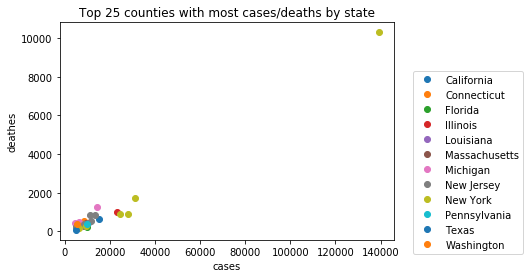

In [8]:
groups = top.groupby("state")
for name, group in groups:
    plt.plot(group["cases"], group["deaths"], marker="o", linestyle="", label=name)
plt.legend(loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.8))
plt.title('Top 25 counties with most cases/deaths by state')
plt.xlabel('cases')
plt.ylabel('deathes')

## Methods
1. Model capability using multiple linear regression.  
2. Apply multivariate bootstrap techniques with hypothesis testing for model selection.  
3. Clustering (hierarchical clustering) for capability classification based on US regions. 

## 1. Feature Selection
Before conducting regression, we did performed feature selection with stepwise selection and random forest. 

In [53]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [106]:
# remove those without fips_code
data.dropna(subset = ["fips_code"], inplace=True)
data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()

In [105]:
X = data.drop(['fips_code', 'date', 'county', 'State', 'county_x', 'cases', 'deaths', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_c = data['cases']
Y_d = data['deaths']

In [107]:
# for predicting cases
result = stepwise_selection(X, Y_c)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  population_65                  with p-value 9.47915e-120
Add  Population..65..               with p-value 9.48064e-120
Add  population                     with p-value 0.00326538
Add  Population_2010                with p-value 6.79455e-28
Add  Population                     with p-value 1.16506e-29
Add  licensed_all_beds              with p-value 0.000218988
Add  staffed_all_beds               with p-value 4.49716e-05
Add  Licensed.All.Beds              with p-value 3.6604e-07
Add  Staffed.All.Beds               with p-value 4.49716e-05
Add  Staffed.ICU.Beds               with p-value 0.00784317
Add  All.Bed.Occupancy.Rate         with p-value 0.0075478
Add  staffed_icu_beds               with p-value 0.00529668
Add  Description                    with p-value 0.00711259
Add  Urban_Influence_Code_2013      with p-value 0.000471977


In [72]:
# for predicting deaths
result = stepwise_selection(X, Y_d)
print('resulting features:')
print(result)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  population_65                  with p-value 1.3761e-94
Add  Population..65..               with p-value 1.37628e-94
Add  population                     with p-value 1.83961e-06
Add  Population_2010                with p-value 1.2495e-34
Add  Population                     with p-value 1.57941e-39
Add  All.Bed.Occupancy.Rate         with p-value 0.00212625
Add  all_bed_occupancy_rate         with p-value 0.00212625
resulting features:
['population_65', 'Population..65..', 'population', 'Population_2010', 'Population', 'All.Bed.Occupancy.Rate', 'all_bed_occupancy_rate']


In [64]:
fit = ols('cases ~ C(state) + population + licensed_all_beds + population_65 + staffed_all_beds + population_20 + licensed_all_beds_per_1000_people', data = data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cases   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     33.03
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          1.62e-247
Time:                        12:46:17   Log-Likelihood:                -19130.
No. Observations:                2268   AIC:                         3.837e+04
Df Residuals:                    2211   BIC:                         3.870e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          -118.4524    148.298     -0.799      0.425    -409.271     172.366
C(state)[T.Alaska]                   83.6022    385.705      0.217      0.828    -672.779     839.984
C(state)[T.Arizona]                -891.6015    342.925     -2.600      0.009   -1564.091    -219.112
C(state)[T.Arkansas]                 23.1356    212.770      0.109      0.913    -394.113     440.385
C(state)[T.California]             -796.2678    221.195     -3.600      0.000   -1230.040    -362.496
C(state)[T.Colorado]                 95.3452    227.515      0.419      0.675    -350.820     541.511
C(state)[T.Connecticut]            1389.6419    427.882      3.248      0.001     550.549    2228.735
C(state)[T.Delaware]                 35.3038    669.698      0.053      0.958   -1278.000    1348.607
C(state)[T.District of Columbia]    917.0896   1154.039      0.795      0.427   -1346.024    3180.204
C(state)[T.Florida]                -849.1790    216.384     -3.924      0.000   -1273.517    -424.841
C(state)[T.Georgia]                 128.5200    181.932      0.706      0.480    -228.256     485.296
C(state)[T.Hawaii]                 -761.5004    584.976     -1.302      0.193   -1908.659     385.659
C(state)[T.Idaho]                    74.9603    272.890      0.275      0.784    -460.188     610.108
C(state)[T.Illinois]                144.0346    194.581      0.740      0.459    -237.545     525.615
C(state)[T.Indiana]                 114.7368    195.858      0.586      0.558    -269.347     498.821
C(state)[T.Iowa]                     58.4821    195.197      0.300      0.765    -324.306     441.270
C(state)[T.Kansas]                   86.3275    203.052      0.425      0.671    -311.865     484.520
C(state)[T.Kentucky]                 25.8688    196.134      0.132      0.895    -358.757     410.494
C(state)[T.Louisiana]               360.4632    207.873      1.734      0.083     -47.184     768.110
C(state)[T.Maine]                  -141.9174    326.037     -0.435      0.663    -781.288     497.453
C(state)[T.Maryland]                175.8967    292.447      0.601      0.548    -397.603     749.396
C(state)[T.Massachusetts]          1479.8655    338.010      4.378      0.000     817.015    2142.716
C(state)[T.Michigan]                213.4987    200.295      1.066      0.287    -179.286     606.284
C(state)[T.Minnesota]               -35.9733    197.573     -0.182      0.856    -423.420     351.474
C(state)[T.Mississippi]              95.7459    196.153      0.488      0.626    -288.917     480.408
C(state)[T.Missouri]                  4.0589    204.388      0.020      0.984    -396.754     404.872
C(state)[T.Montana]                  72.8312    261.736      0.278      0.781    -440.443     586.105
C(state)[T.Nebraska]   

In [141]:
# for predicting cases
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_c, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[0:6]

,importance
peopleinpoverty2018,0.034703
medianhouseholdincome,0.032211
All.Bed.Occupancy.Rate,0.030086
icu_bed_occupancy_rate,0.029075
ICU.Bed.Occupancy.Rate,0.028878
Population..65..,0.028759


In [79]:
# for predicting deaths
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_d, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[0:5]

,importance
Population..20..,0.034606
icu_bed_occupancy_rate,0.032789
population_20,0.032676
ICU.Bed.Occupancy.Rate,0.032097
Population,0.032012


## 2.1 Regression with stepwise selection

In [110]:
data.columns = data.columns.str.strip().str.lower().str.replace('.', '_').str.replace('(', '').str.replace(')', '')

In [111]:
# predicting cases
fit = ols('cases ~ population_65 + population__65__ + population + population_2010 + population + licensed_all_beds + staffed_all_beds + licensed_all_beds + staffed_all_beds + staffed_icu_beds + all_bed_occupancy_rate + staffed_icu_beds + description + urban_influence_code_2013', data = data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cases   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     64.10
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          9.47e-153
Time:                        13:00:32   Log-Likelihood:                -11855.
No. Observations:                1364   AIC:                         2.374e+04
Df Residuals:                    1347   BIC:                         2.383e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================
                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      158.8689    184.743      0.860      0.390    -203.547     521.285
description[T.Metro - Counties in metro areas of 250,000 to 1 million population]                             -913.7723    143.659     -6.361      0.000   -1195.592    -631.953
description[T.Metro - Counties in metro areas of fewer than 250,000 population]                               -782.5562    149.468     -5.236      0.000   -1075.772    -489.341
description[T.Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area]      -450.3569    649.005     -0.694      0.488   -1723.527     822.813
description[T.Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area]  -495.9737    709.589     -0.699      0.485   -1887.994     896.046
description[T.Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area]                       -514.4998    268.338     -1.917      0.055   -1040.906      11.906
description[T.Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area]                   -512.8691    475.905     -1.078      0.281   -1446.464     420.726
description[T.Nonmetro - Urban population of 20,000 or more, adjacent to a metro area]                        -655.6320    232.367     -2.822      0.005   -1111.472    -199.792
description[T.Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area]                    -625.5612    434.374     -1.440      0.150   -1477.683     226.561
population_65                                                                                                    0.0085      0.002      5.185      0.000       0.005       0.012
population__65__                                                                                                 0.0085      0.002      5.185      0.000       0.005       0.012
population[0]                                                                                                   -0.0094      0.001    -13.630      0.000      -0.011      -0.008
population[1]                                                                                                   -0.0094      0.001    -13.630      0.000      -0.011      -0.008
population_2010                                                                                                  0.0193      0.002     12.729      0.000       0.016       0.022
licensed_all_beds[0]                                                      

In [112]:
# predicted deaths
fit = ols('deaths ~ population_65 + population__65__ + population + population_2010 + population + all_bed_occupancy_rate + all_bed_occupancy_rate', data = data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deaths   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     191.6
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          2.67e-130
Time:                        13:02:06   Log-Likelihood:                -7836.4
No. Observations:                1364   AIC:                         1.568e+04
Df Residuals:                    1359   BIC:                         1.571e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -21.5916      6.136     -3.519      0.000     -33.629      -9.555
population_65                 0.0005   8.49e-05      5.553      0.000       0.000       0.001
population__65__              0.0005   8.49e-05      5.553      0.000       0.000       0.001
population[0]                -0.0005    3.5e-05    -13.835      0.000      -0.001      -0.000
population[1]                -0.0005    3.5e-05    -13.835      0.000      -0.001      -0.000
population_2010               0.0010   7.71e-05     12.913      0.000       0.001       0.001
all_bed_occupancy_rate[0]    18.7380      6.088      3.078      0.002       6.795      30.681
all_bed_occupancy_rate[1]    18.7380      6.088      3.078      0.002       6.795      30.681
==============================================================================
Omnibus:                     2094.293   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1190704.301
Skew:                           9.090   Prob(JB):                         0.00
Kurtosis:                     146.598   Cond. No.                     3.47e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.8e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 2.2 Regression with random forest top5 variables

In [143]:
# for predicting cases
X_c = X[['medianhouseholdincome', 'peopleinpoverty2018', 'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population__65__']]


In [144]:
# for predicting cases
X_train, X_valid, y_train, y_valid = train_test_split(X_c, Y_c, test_size = 0.7, random_state = 1)

model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
rf_predictions = model.predict(X_valid)
rf_probs = model.predict_proba(X_valid)[:, 1]
#roc_value = roc_auc_score(y_valid, rf_probs, multi_class="ovr")

ValueError: could not convert string to float: '47,982'

In [139]:
sk_report = classification_report(
    digits=6,
    y_true=y_valid, 
    y_pred=model.predict(X_valid))
print(sk_report)

              precision    recall  f1-score   support

           1   0.200000  0.083333  0.117647        24
           2   0.428571  0.130435  0.200000        23
           3   0.000000  0.000000  0.000000        12
           4   0.062500  0.066667  0.064516        30
           5   0.071429  0.176471  0.101695        17
           6   0.042254  0.150000  0.065934        20
           7   0.000000  0.000000  0.000000        13
           8   0.000000  0.000000  0.000000        14
           9   0.000000  0.000000  0.000000        17
          10   0.054054  0.166667  0.081633        12
          11   0.000000  0.000000  0.000000        16
          12   0.000000  0.000000  0.000000        14
          13   0.000000  0.000000  0.000000        15
          14   0.000000  0.000000  0.000000        17
          15   0.100000  0.083333  0.090909        12
          16   0.000000  0.000000  0.000000        15
          17   0.000000  0.000000  0.000000         7
          18   0.000000  0.

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
